In [1]:
# Import libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# set plot size
plt.rcParams["figure.figsize"] = (20, 13)
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
interactions_train = pd.read_csv("./KuaiRec 2.0/data/big_matrix.csv")
interactions_train.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,0,3649,13838,10867,2020-07-05 00:08:23.438,20200705,1.593879e+09,1.273397
1,0,9598,13665,10984,2020-07-05 00:13:41.297,20200705,1.593879e+09,1.244082
2,0,5262,851,7908,2020-07-05 00:16:06.687,20200705,1.593879e+09,0.107613
3,0,1963,862,9590,2020-07-05 00:20:26.792,20200705,1.593880e+09,0.089885
4,0,8234,858,11000,2020-07-05 00:43:05.128,20200705,1.593881e+09,0.078000


In [3]:
interactions_test = pd.read_csv("./KuaiRec 2.0/data/small_matrix.csv")
interactions_test.head()

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364


# Check for missing/error values

In [5]:
print(f"=== Check for nan ===")
for column in interactions_train.columns:
    if not interactions_train[interactions_train[column].isna()].empty:
        print(f"Column: {column}")


=== Check for nan ===


In [6]:
print(f"=== Check for nan ===")
for column in interactions_test.columns:
    if not interactions_test[interactions_test[column].isna()].empty:
        print(f"Column: {column}")


=== Check for nan ===
Column: time
Column: date
Column: timestamp


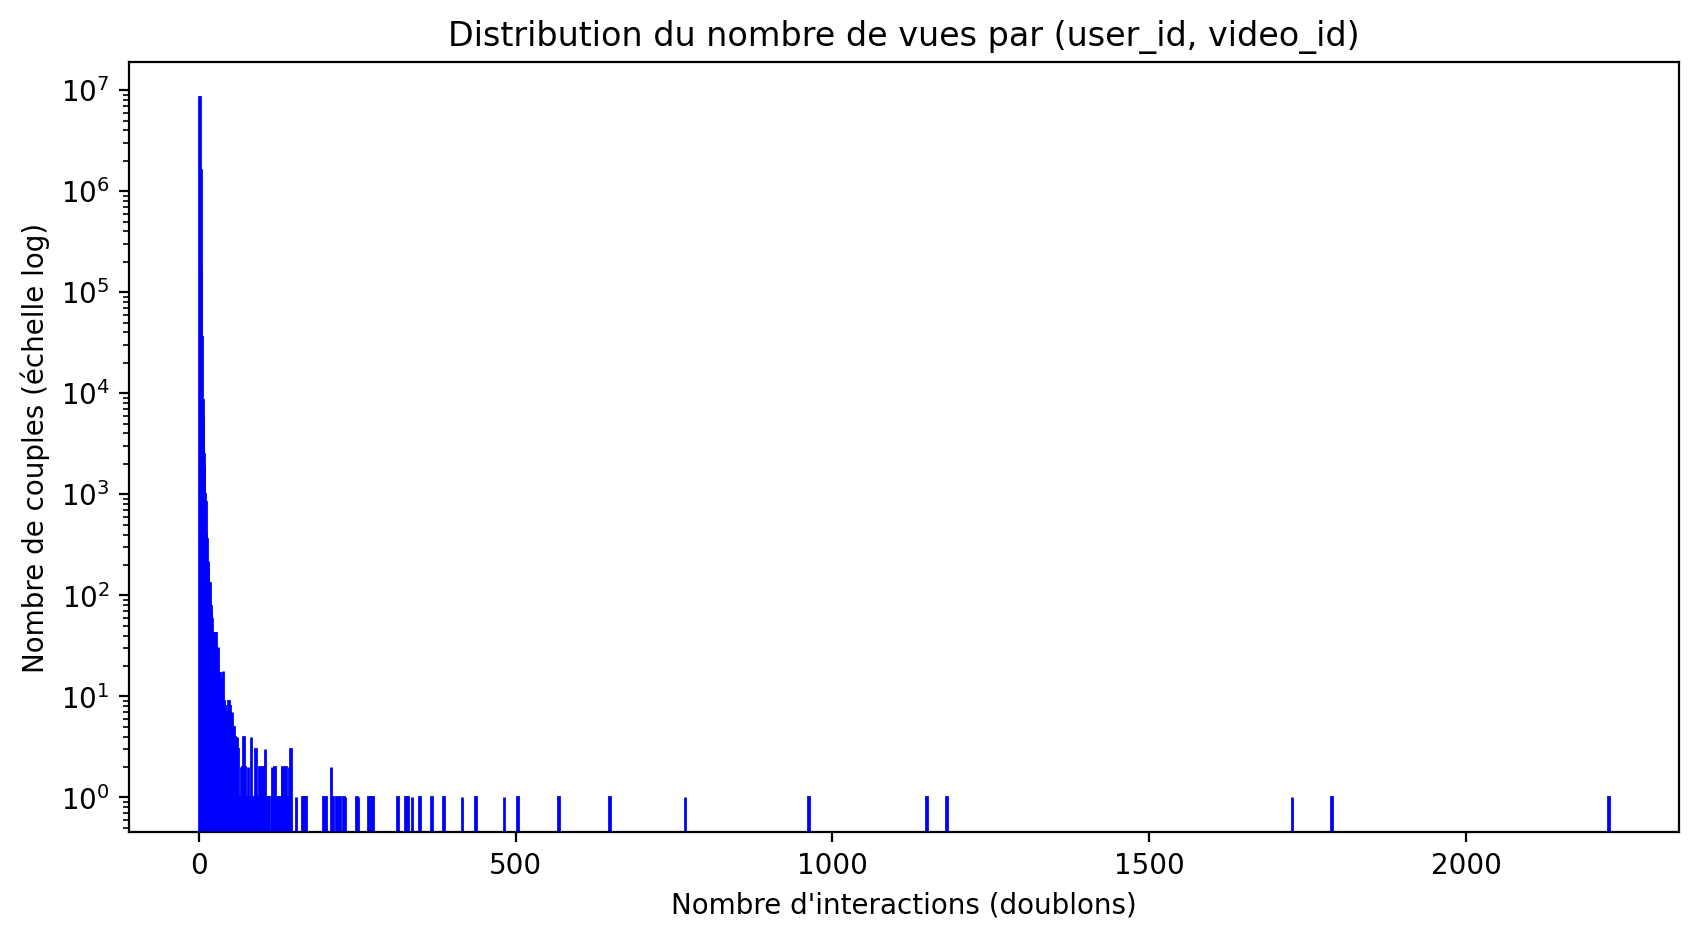

In [6]:
dups = interactions_train.groupby(['user_id', 'video_id']).size().reset_index(name='count')



# Visualiser la distribution (logarithmique si skew)
plt.figure(figsize=(10, 5))
plt.hist(dups['count'], bins=range(1, dups['count'].max() + 2), edgecolor='blue', log=True)
plt.title("Distribution du nombre de vues par (user_id, video_id)")
plt.xlabel("Nombre d'interactions (doublons)")
plt.ylabel("Nombre de couples (échelle log)")
plt.grid(False)
plt.show()

In [7]:
ratio = (interactions_train['watch_ratio'] > 1).sum() / len(interactions_train)
print(f"Nombre de watch_ratio > 1 : {(interactions_train['watch_ratio'] > 1).sum()}")
print(f"Le ratio de watch_ratio > 1 est : {ratio:.2%}")

Nombre de watch_ratio > 1 : 4237441
Le ratio de watch_ratio > 1 est : 33.82%


### On prends le last

In [4]:
interactions_train['date'] = pd.to_datetime(interactions_train['date'])
interactions_train_filtered = interactions_train.sort_values('date').groupby(['user_id', 'video_id']).agg({
    'watch_ratio': 'last' 
}).reset_index()

In [5]:
interactions_train_filtered['rating'] = interactions_train_filtered['watch_ratio'].clip(upper=5.0)
interactions_test['rating'] = interactions_test['watch_ratio'].clip(upper=5.0)


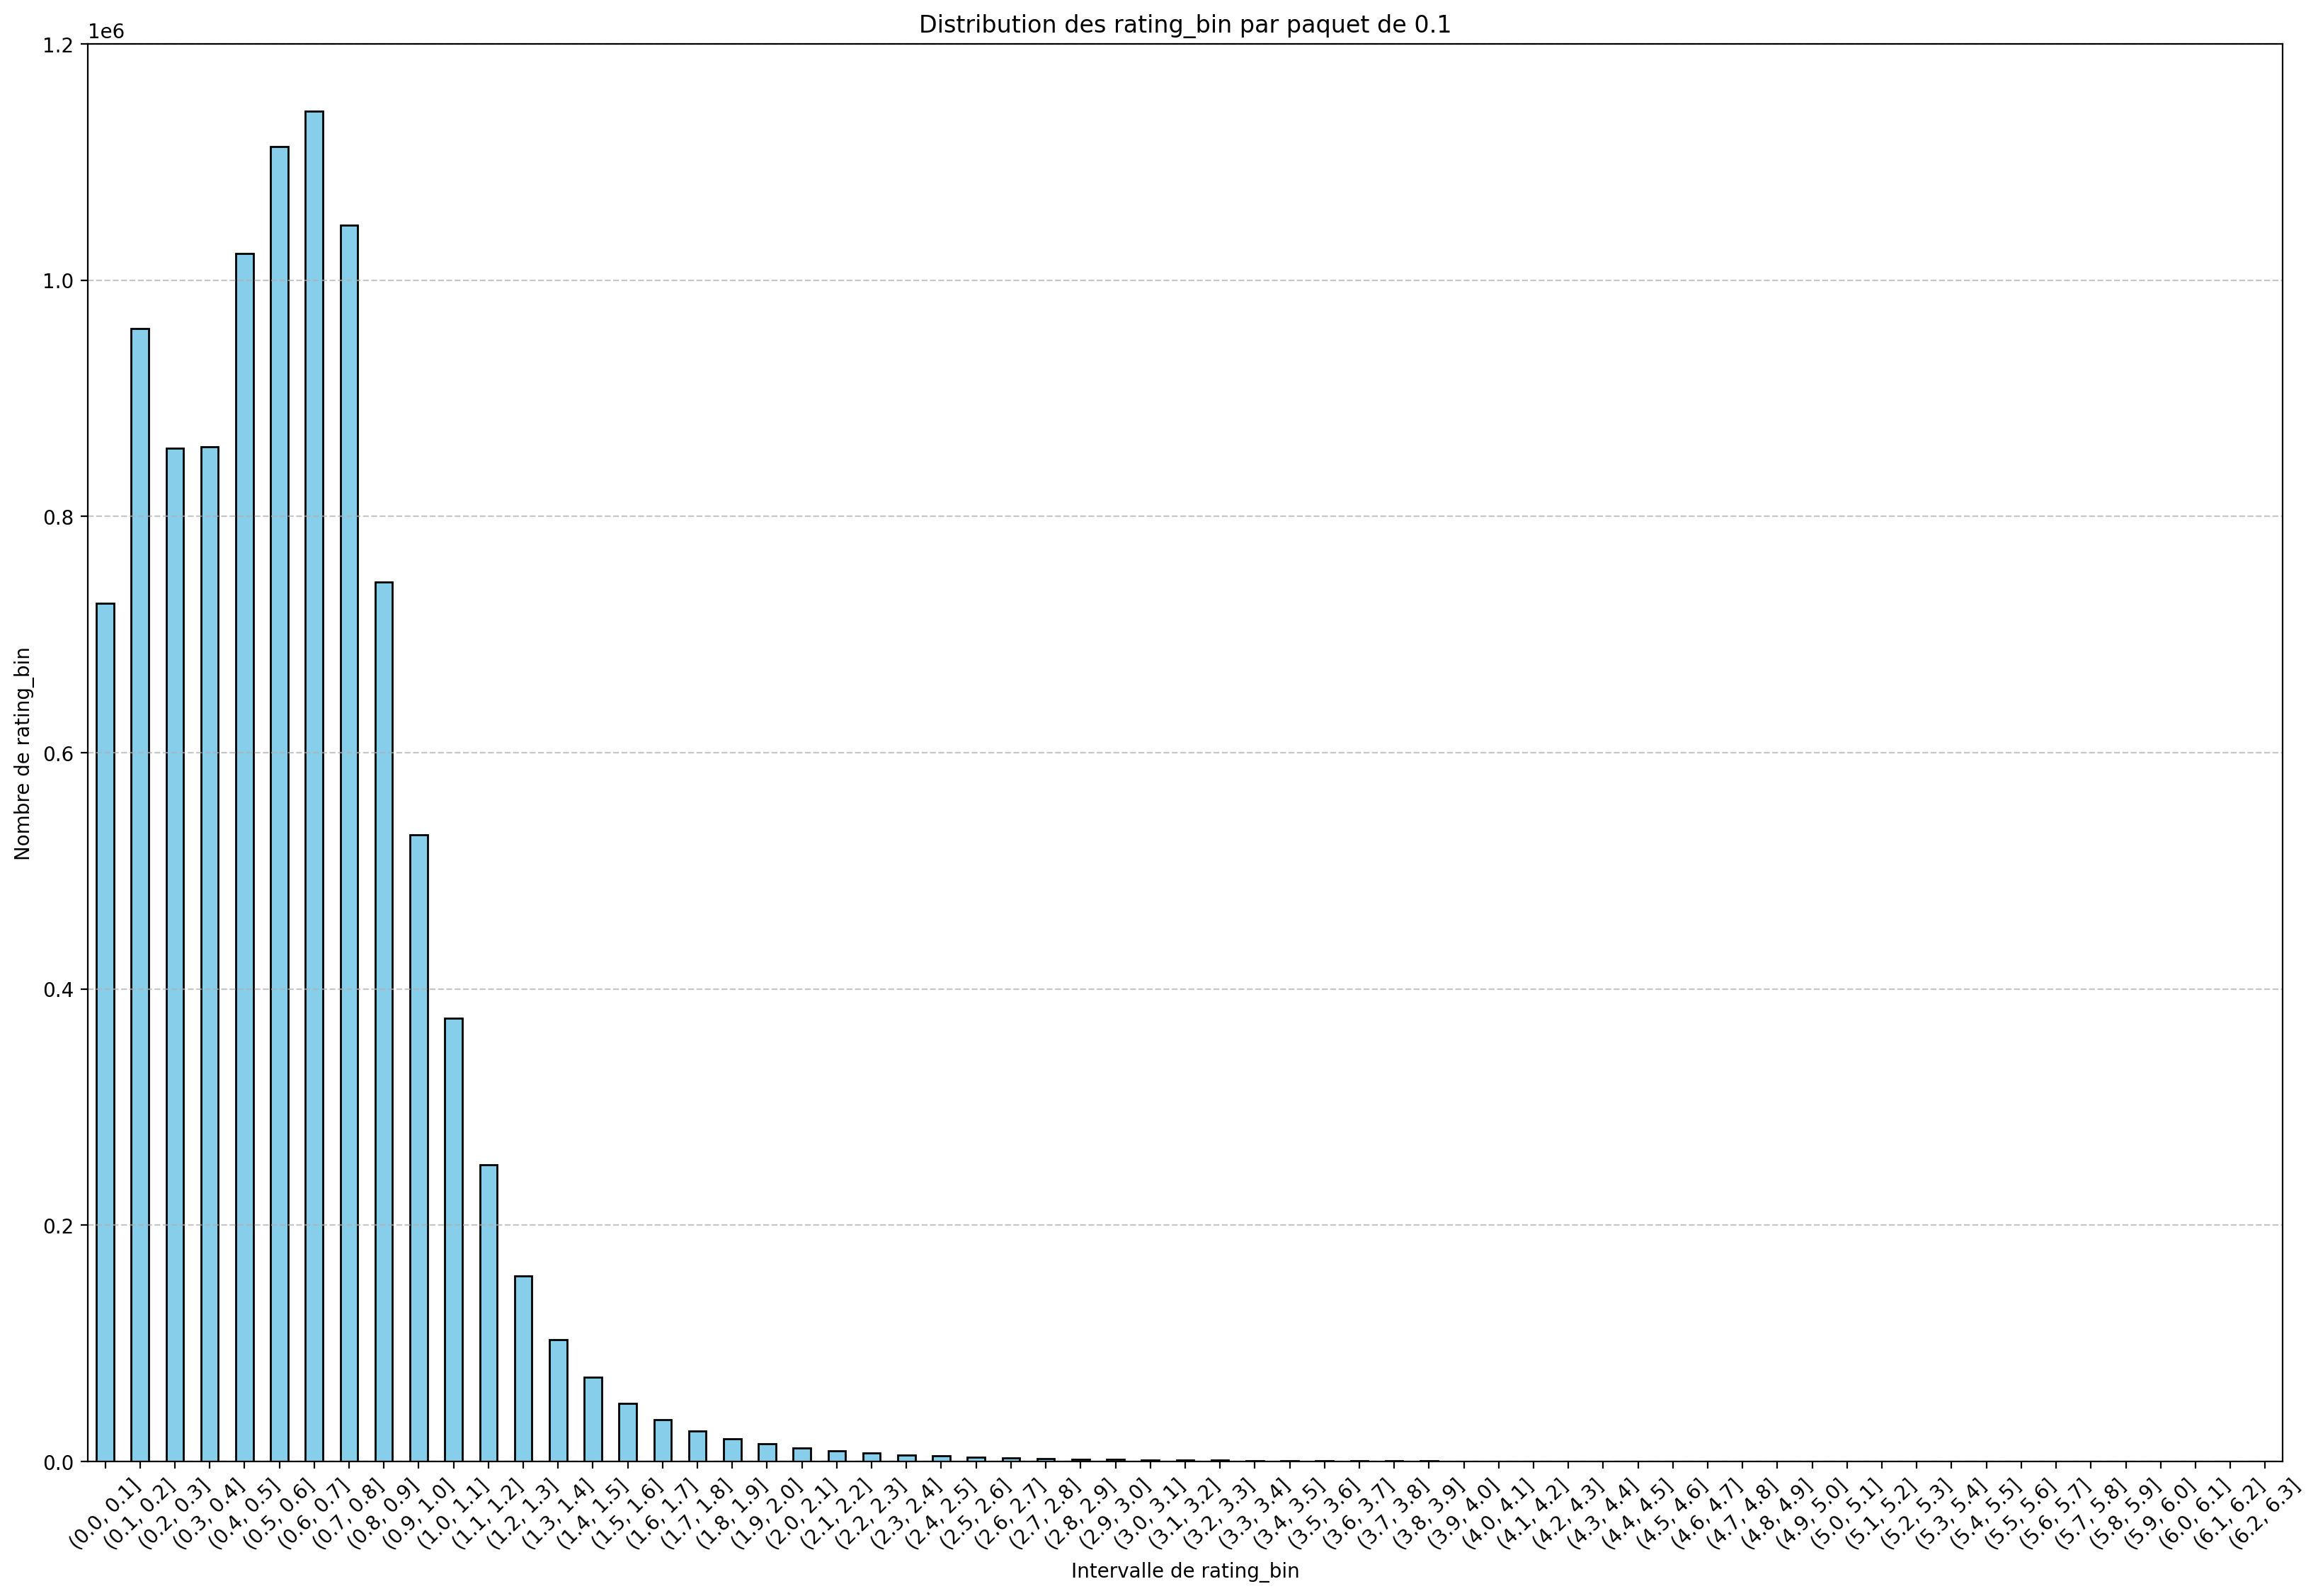

In [46]:
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(output_distribution='normal')
#interactions_test['rating'] = qt.fit_transform(interactions_test[['watch_ratio']])


# Convertir les prédictions en pandas si ce n'est pas déjà fait
#interactions_train_filtered['rating'] = qt.fit_transform(interactions_train_filtered[['watch_ratio']])
interactions_train_filtered['rating'] = np.log1p(interactions_train_filtered['watch_ratio'])
#interactions_train_filtered['rating'] = (np.log1p(interactions_train_filtered['watch_ratio']) / np.log1p(np.max(interactions_train_filtered['rating']))).clip(upper=1.0)
interactions_train_filtered['rating_bin'] = pd.cut(interactions_train_filtered['rating'], bins=np.arange(0, np.max(interactions_train_filtered['rating']), 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_train_filtered['rating_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des rating_bin par paquet de 0.1")
plt.xlabel("Intervalle de rating_bin")
plt.ylabel("Nombre de rating_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
# Vérifier les valeurs de rating > 1 et < 0 dans interactions_train_filtered et interactions_test
print("interactions_train_filtered :")
print("Nombre de ratings > 1 :", (interactions_train_filtered['rating'] > 1).sum())
print(f"Ratio de ratings > 1 : {(interactions_train_filtered['rating'] > 0.9).sum() / len(interactions_train_filtered):.2%}")

interactions_train_filtered :
Nombre de ratings > 1 : 3562705
Ratio de ratings > 1 : 34.59%


In [15]:
import numpy as np

# watch_ratios : matrice utilisateur × vidéo avec watch ratios
# calcule proportion d'interactions > 1 sur toutes les interactions non-nulles
interactions = (interactions_train_filtered['rating'] > 0).sum()
pertinentes = (interactions_train_filtered['rating'] > 1).sum()
proportion = pertinentes / interactions

print(f"Proportion d'interactions pertinentes (watch_ratio > 1) : {proportion:.2%}")


Proportion d'interactions pertinentes (watch_ratio > 1) : 35.05%


In [49]:
# Calculer pour chaque utilisateur le ratio d'interactions avec rating > 0.9
user_ratio = interactions_train_filtered.groupby('user_id').apply(lambda df: (df['rating'] > 0.9).mean())

# Afficher la moyenne de ces ratios sur tous les utilisateurs
print("Moyenne du ratio d'interactions avec rating > 0.9 par utilisateur :", user_ratio.mean())

Moyenne du ratio d'interactions avec rating > 0.9 par utilisateur : 0.16994528394575523


C:\Users\letru\AppData\Local\Temp\ipykernel_15020\250367489.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_ratio = interactions_train_filtered.groupby('user_id').apply(lambda df: (df['rating'] > 0.9).mean())


In [ ]:
# Calculer pour chaque utilisateur le nombre d'interactions avec rating > 0.9
user_count = interactions_train_filtered.groupby('user_id').apply(lambda df: (df['rating'] > 0.9).sum())

# Afficher la moyenne de ces comptes sur tous les utilisateurs
print("Moyenne du nombre d'interactions avec rating > 0.9 par utilisateur :", user_count.mean()))

Moyenne du nombre d'interactions avec rating > 0.9 par utilisateur : 235.9665551839465


C:\Users\letru\AppData\Local\Temp\ipykernel_15020\4158455510.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_count = interactions_train_filtered.groupby('user_id').apply(lambda df: (df['rating'] > 0.9).sum())


In [28]:
interactions_test['rating'] = np.log1p(interactions_test['watch_ratio'])
#interactions_test['rating'] = qt.transform(interactions_test[['watch_ratio']])
interactions_test

,user_id,video_id,play_duration,video_duration,time,date,timestamp,watch_ratio,rating
0,14,148,4381,6067,2020-07-05 05:27:48.378,20200705.0,1.593898e+09,0.722103,0.543546
1,14,183,11635,6100,2020-07-05 05:28:00.057,20200705.0,1.593898e+09,1.907377,1.067251
2,14,3649,22422,10867,2020-07-05 05:29:09.479,20200705.0,1.593898e+09,2.063311,1.119496
3,14,5262,4479,7908,2020-07-05 05:30:43.285,20200705.0,1.593898e+09,0.566388,0.448773
4,14,8234,4602,11000,2020-07-05 05:35:43.459,20200705.0,1.593899e+09,0.418364,0.349504
...,...,...,...,...,...,...,...,...,...
4676565,7162,2267,11908,5467,NaN,NaN,NaN,2.178160,1.156302
4676566,7162,2065,11919,6067,NaN,NaN,NaN,1.964562,1.086729
4676567,7162,1296,16690,19870,NaN,NaN,NaN,0.839960,0.609744
4676568,7162,4822,11862,24400,NaN,NaN,NaN,0.486148,0.396187


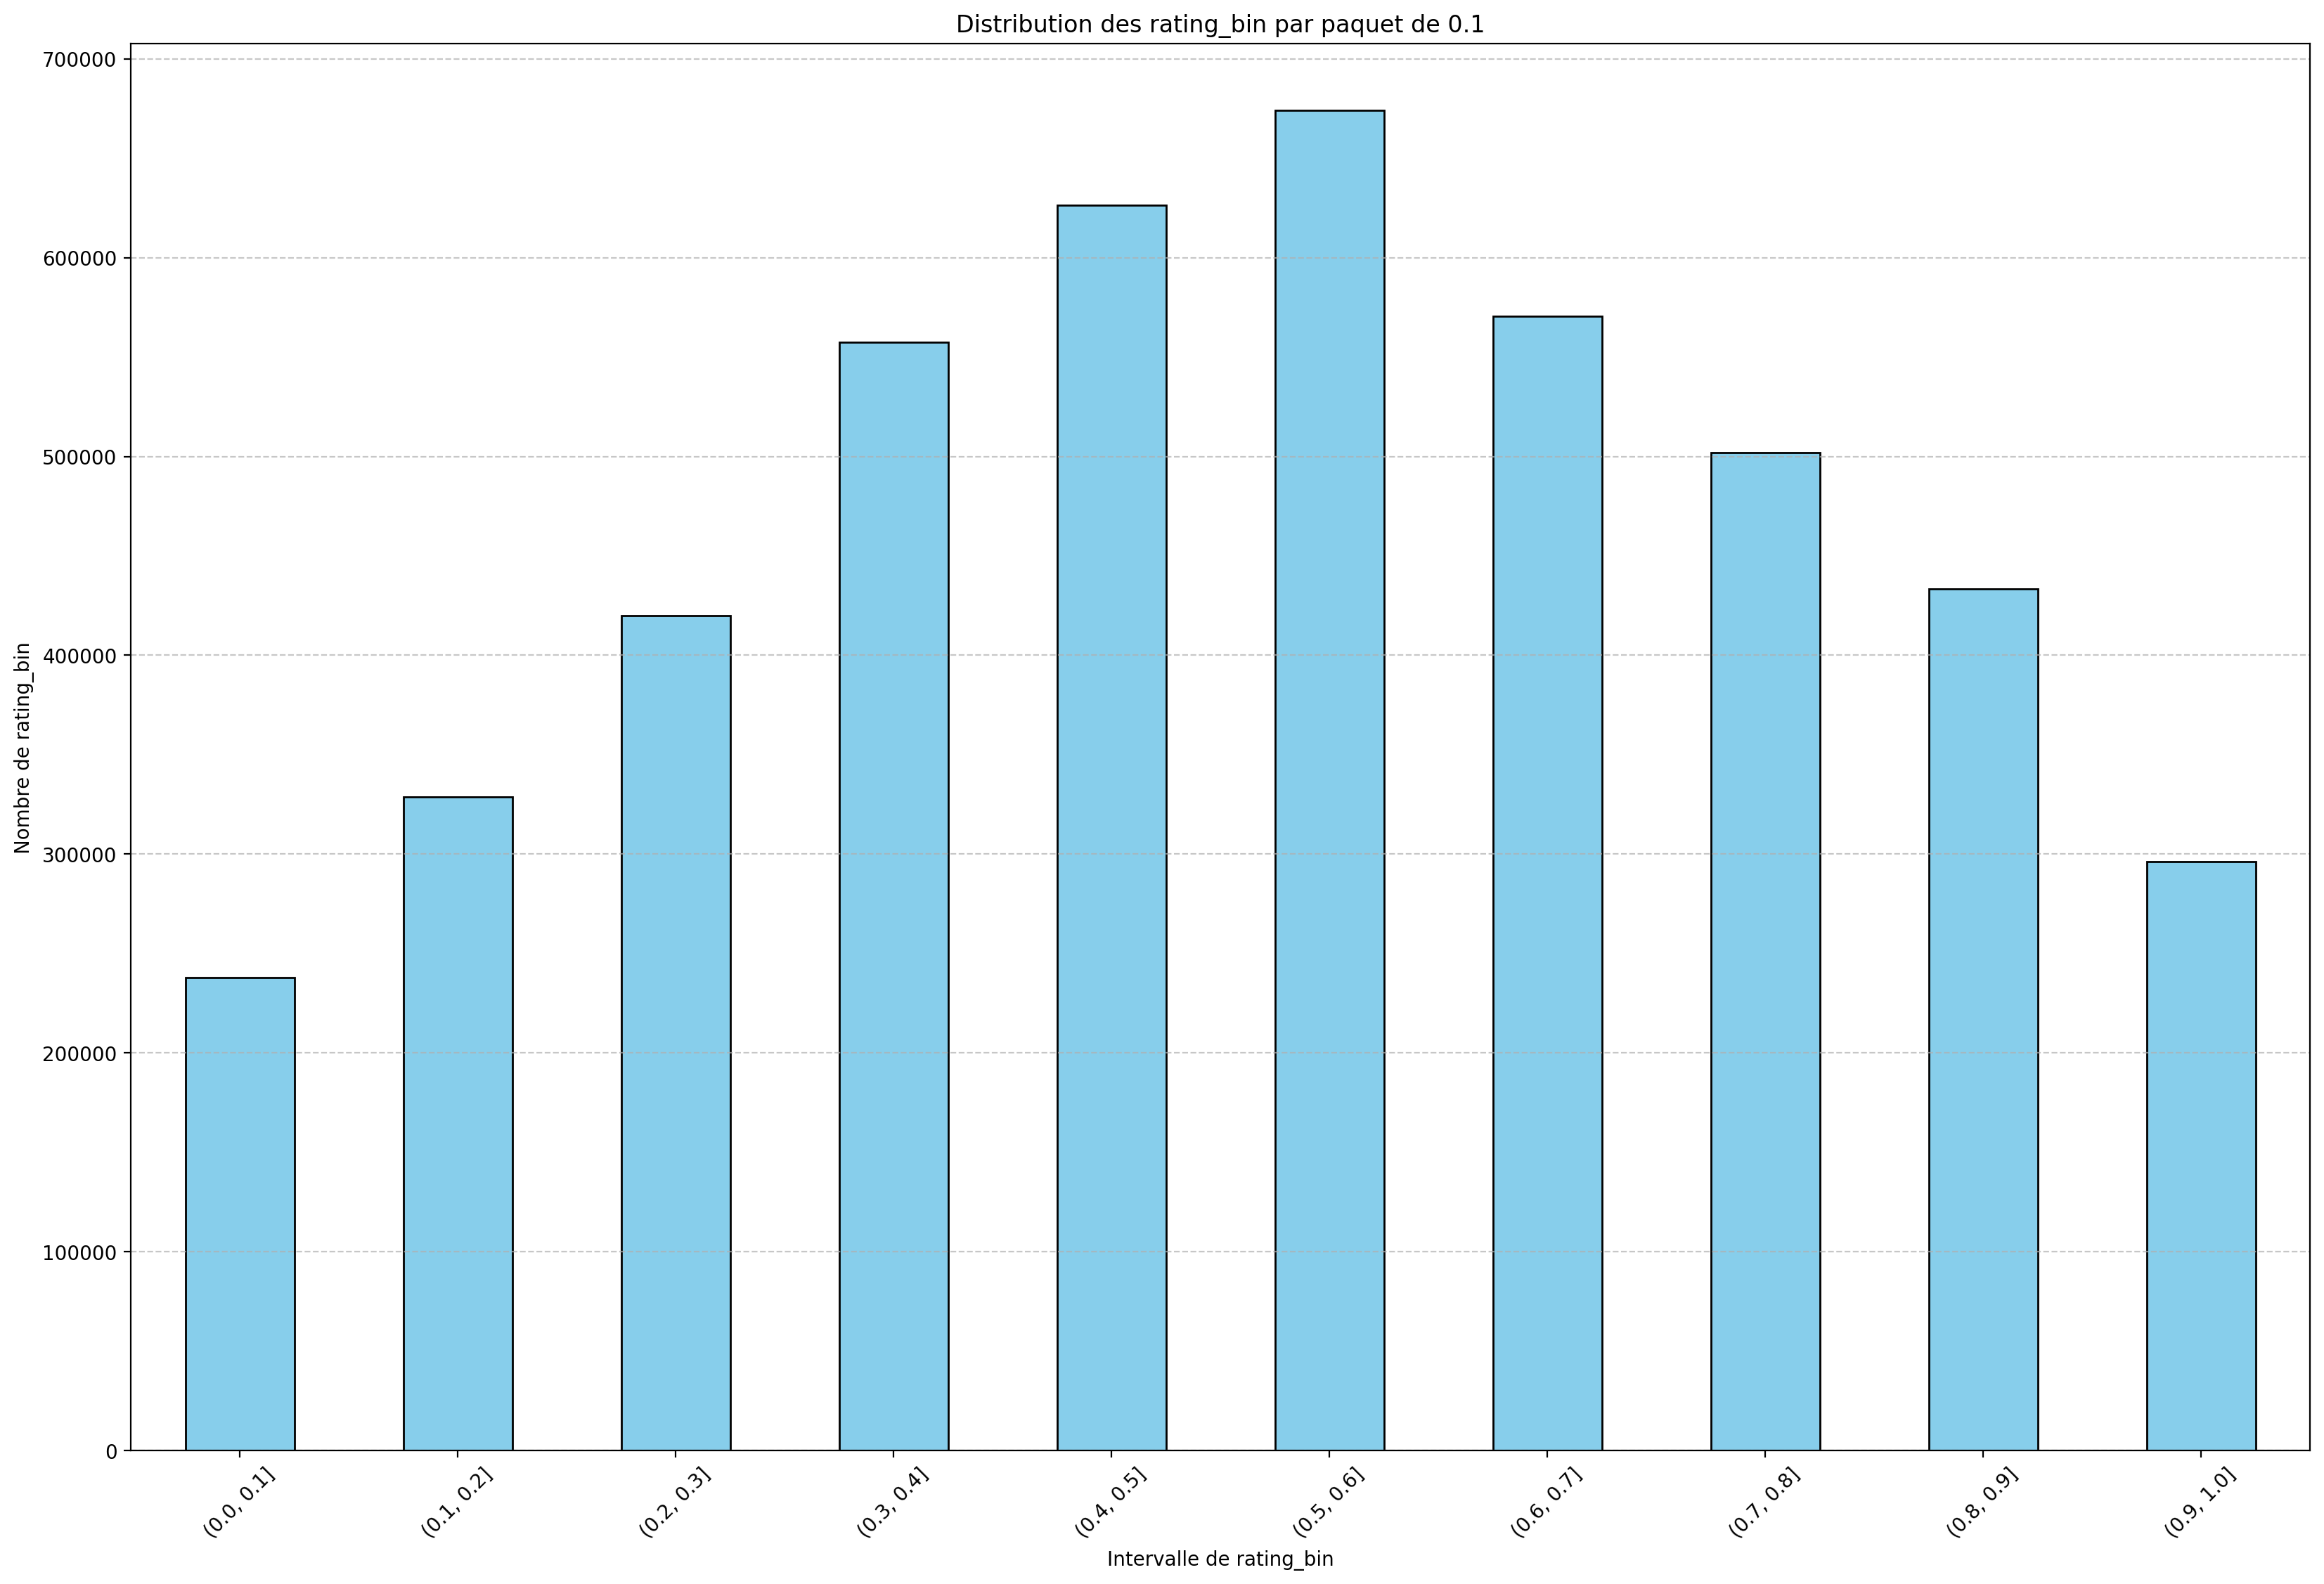

In [ ]:
interactions_test['rating_bin'] = pd.cut(interactions_test['rating'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = interactions_test['rating_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des rating_bin par paquet de 0.1")
plt.xlabel("Intervalle de rating_bin")
plt.ylabel("Nombre de rating_bin")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [6]:
interactions_train_filtered[['user_id', 'video_id', 'rating']].to_csv("interactions_train.csv", index=False)
interactions_test[['user_id', 'video_id', 'rating']].to_csv("interactions_test.csv", index=False)


# ALS

In [7]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import matplotlib.pyplot as plt
import logging

In [8]:
spark = SparkSession.builder.appName("ALSMatrixFactorisation") .master("local[*]").config("spark.driver.memory", "12g") .getOrCreate()

In [9]:
df = spark.read.option("header", "true").csv("./interactions_train.csv")
df.show(100, truncate=True)

+-------+--------+------------------+
|user_id|video_id|            rating|
+-------+--------+------------------+
|      0|      42| 1.098951081407222|
|      0|      67|  2.75963546610974|
|      0|      80|1.1880172413793104|
|      0|     110|1.4086274509803922|
|      0|     128| 1.281866973356335|
|      0|     130|0.0795647399420984|
|      0|     133|2.4584473324213407|
|      0|     139|0.0725128205128205|
|      0|     147|0.0765768884580765|
|      0|     151| 1.614911509978662|
|      0|     152|2.3260869565217392|
|      0|     154| 4.353646984527945|
|      0|     166|0.1446428571428571|
|      0|     169|1.3603972560663458|
|      0|     170|1.3742014280345736|
|      0|     171|               5.0|
|      0|     179|2.1577385857919893|
|      0|     180|1.2539090909090909|
|      0|     183|0.1304918032786885|
|      0|     188|1.3476706069335451|
|      0|     203|0.0747104613632048|
|      0|     206|0.0795191353259071|
|      0|     207|0.1132786885245901|
|      0|   

In [10]:
from pyspark.sql.functions import col, when

In [11]:
indexer = [
    StringIndexer(inputCol=column, outputCol=column + "_index")
    for column in ['user_id', 'video_id']
]

pipeline = Pipeline(stages=indexer)

# 2. Entraîner le pipeline
pipeline_model = pipeline.fit(df)

# 3. Transformer les données d'entraînement
transformed = pipeline_model.transform(df)

# 4. Forcer rating en float
transformed = transformed.withColumn("rating", col("rating").cast("float"))

# 5. Entraîner le modèle ALS

# ------------------------
# Données de test : small_matrix
# ------------------------

# 6. Charger small_matrix.csv
small_matrix_spark = spark.read.option("header", "true").csv("./interactions_test.csv")


# 10. Transformer avec le pipeline entraîné
small_matrix_transformed = pipeline_model.transform(small_matrix_spark)

# 11. Forcer rating en float
small_matrix_transformed = small_matrix_transformed.withColumn("rating", col("rating").cast("float"))


In [12]:


als = ALS(
    maxIter=15,
    regParam=0.01,
    rank=100,
    userCol="user_id_index",
    itemCol="video_id_index",
    ratingCol="rating",
    coldStartStrategy="drop",
    nonnegative=True,
)
model = als.fit(transformed)



# 12. Prédictions
predictions = model.transform(small_matrix_transformed)

# 13. Affichage
predictions.show()

+-------+--------+-----------+-------------+--------------+----------+
|user_id|video_id|     rating|user_id_index|video_id_index|prediction|
+-------+--------+-----------+-------------+--------------+----------+
|    815|    3809|  0.3554762|       6773.0|         496.0| 2.0560515|
|    815|    8495| 0.37398577|       6773.0|        2142.0| 1.0197405|
|    815|    7107|  2.6269925|       6773.0|        3175.0|0.45254818|
|    815|    8291|  1.7278862|       6773.0|        1238.0| 1.7211665|
|    815|     389|  0.4216376|       6773.0|        1645.0| 1.6123314|
|    815|    7081| 0.65285116|       6773.0|        1088.0| 0.7689311|
|    815|    8630|   2.148625|       6773.0|        1580.0| 0.6703862|
|    815|    9882|  1.7546875|       6773.0|        1591.0| 0.7996595|
|    815|    7303| 0.32955554|       6773.0|        1829.0| 1.0257643|
|    815|    4220|   1.576001|       6773.0|        1959.0| 1.1217678|
|    815|    2502|        5.0|       6773.0|        2866.0| 0.5640295|
|    8

In [13]:

predictions_pandas = predictions.toPandas()

# Afficher les premières lignes pour vérifier
print(predictions_pandas.head())

  user_id video_id    rating  user_id_index  video_id_index  prediction
0     815     3809  0.355476         6773.0           496.0    2.056051
1     815     8495  0.373986         6773.0          2142.0    1.019740
2     815     7107  2.626992         6773.0          3175.0    0.452548
3     815     8291  1.727886         6773.0          1238.0    1.721166
4     815      389  0.421638         6773.0          1645.0    1.612331


In [14]:
def evaluate_at_k(df, k, threshold=0.5):
    # Créer la colonne 'relevant' avant toute manipulation
    df['relevant'] = (df['rating'] > threshold).astype(int)

    # Trier les prédictions par utilisateur et score décroissant
    df_sorted = df.sort_values(by=['user_id', 'prediction'], ascending=[True, False])

    # Ajouter le rang de chaque élément par utilisateur
    df_sorted['rank'] = df_sorted.groupby('user_id').cumcount() + 1

    # Garder le top-k par utilisateur
    top_k = df_sorted[df_sorted['rank'] <= k].copy()  # Utiliser .copy() pour éviter la vue

    # Precision@k
    precision_per_user = top_k.groupby('user_id')['relevant'].mean()

    # Recall@k
    total_relevant_per_user = df[df['relevant'] == 1].groupby('user_id').size()
    recall_per_user = top_k.groupby('user_id')['relevant'].sum() / total_relevant_per_user

    # DCG@k
    top_k['dcg'] = (2 ** top_k['relevant'] - 1) / np.log2(top_k['rank'] + 1)
    dcg = top_k.groupby('user_id')['dcg'].sum()

    # IDCG@k
    ideal = df.sort_values(by=['user_id', 'relevant'], ascending=[True, False])
    ideal['rank'] = ideal.groupby('user_id').cumcount() + 1
    ideal_top_k = ideal[ideal['rank'] <= k].copy()
    ideal_top_k['idcg'] = (2 ** ideal_top_k['relevant'] - 1) / np.log2(ideal_top_k['rank'] + 1)
    idcg = ideal_top_k.groupby('user_id')['idcg'].sum()

    ndcg = (dcg / idcg).fillna(0)

    # MAP@k
    def average_precision(group):
        relevant = group['relevant'].values
        if relevant.sum() == 0:
            return 0.0
        precisions = [(relevant[:i+1].sum() / (i+1)) for i in range(len(relevant)) if relevant[i]]
        return np.mean(precisions)

    map_per_user = top_k.groupby('user_id')['relevant'].apply(lambda rel: average_precision(pd.DataFrame({'relevant': rel})))


    # Retourner les résultats sous forme de dictionnaire
    return {
        'precision': precision_per_user.mean(),
        'recall': recall_per_user.mean(),
        'ndcg': ndcg.mean(),
        'map': map_per_user.mean()
    }



In [15]:
from sklearn.metrics import mean_absolute_error

# Calculer la MAE
mae = mean_absolute_error(predictions_pandas['rating'], predictions_pandas['prediction'])
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.3375


In [18]:
count_ratings = predictions_pandas[predictions_pandas['rating'] > 0.9].shape[0]
print(f"Nombre de ratings > 0.9 : {count_ratings/len(predictions_pandas):.2%}")

Nombre de ratings > 0.9 : 39.60%


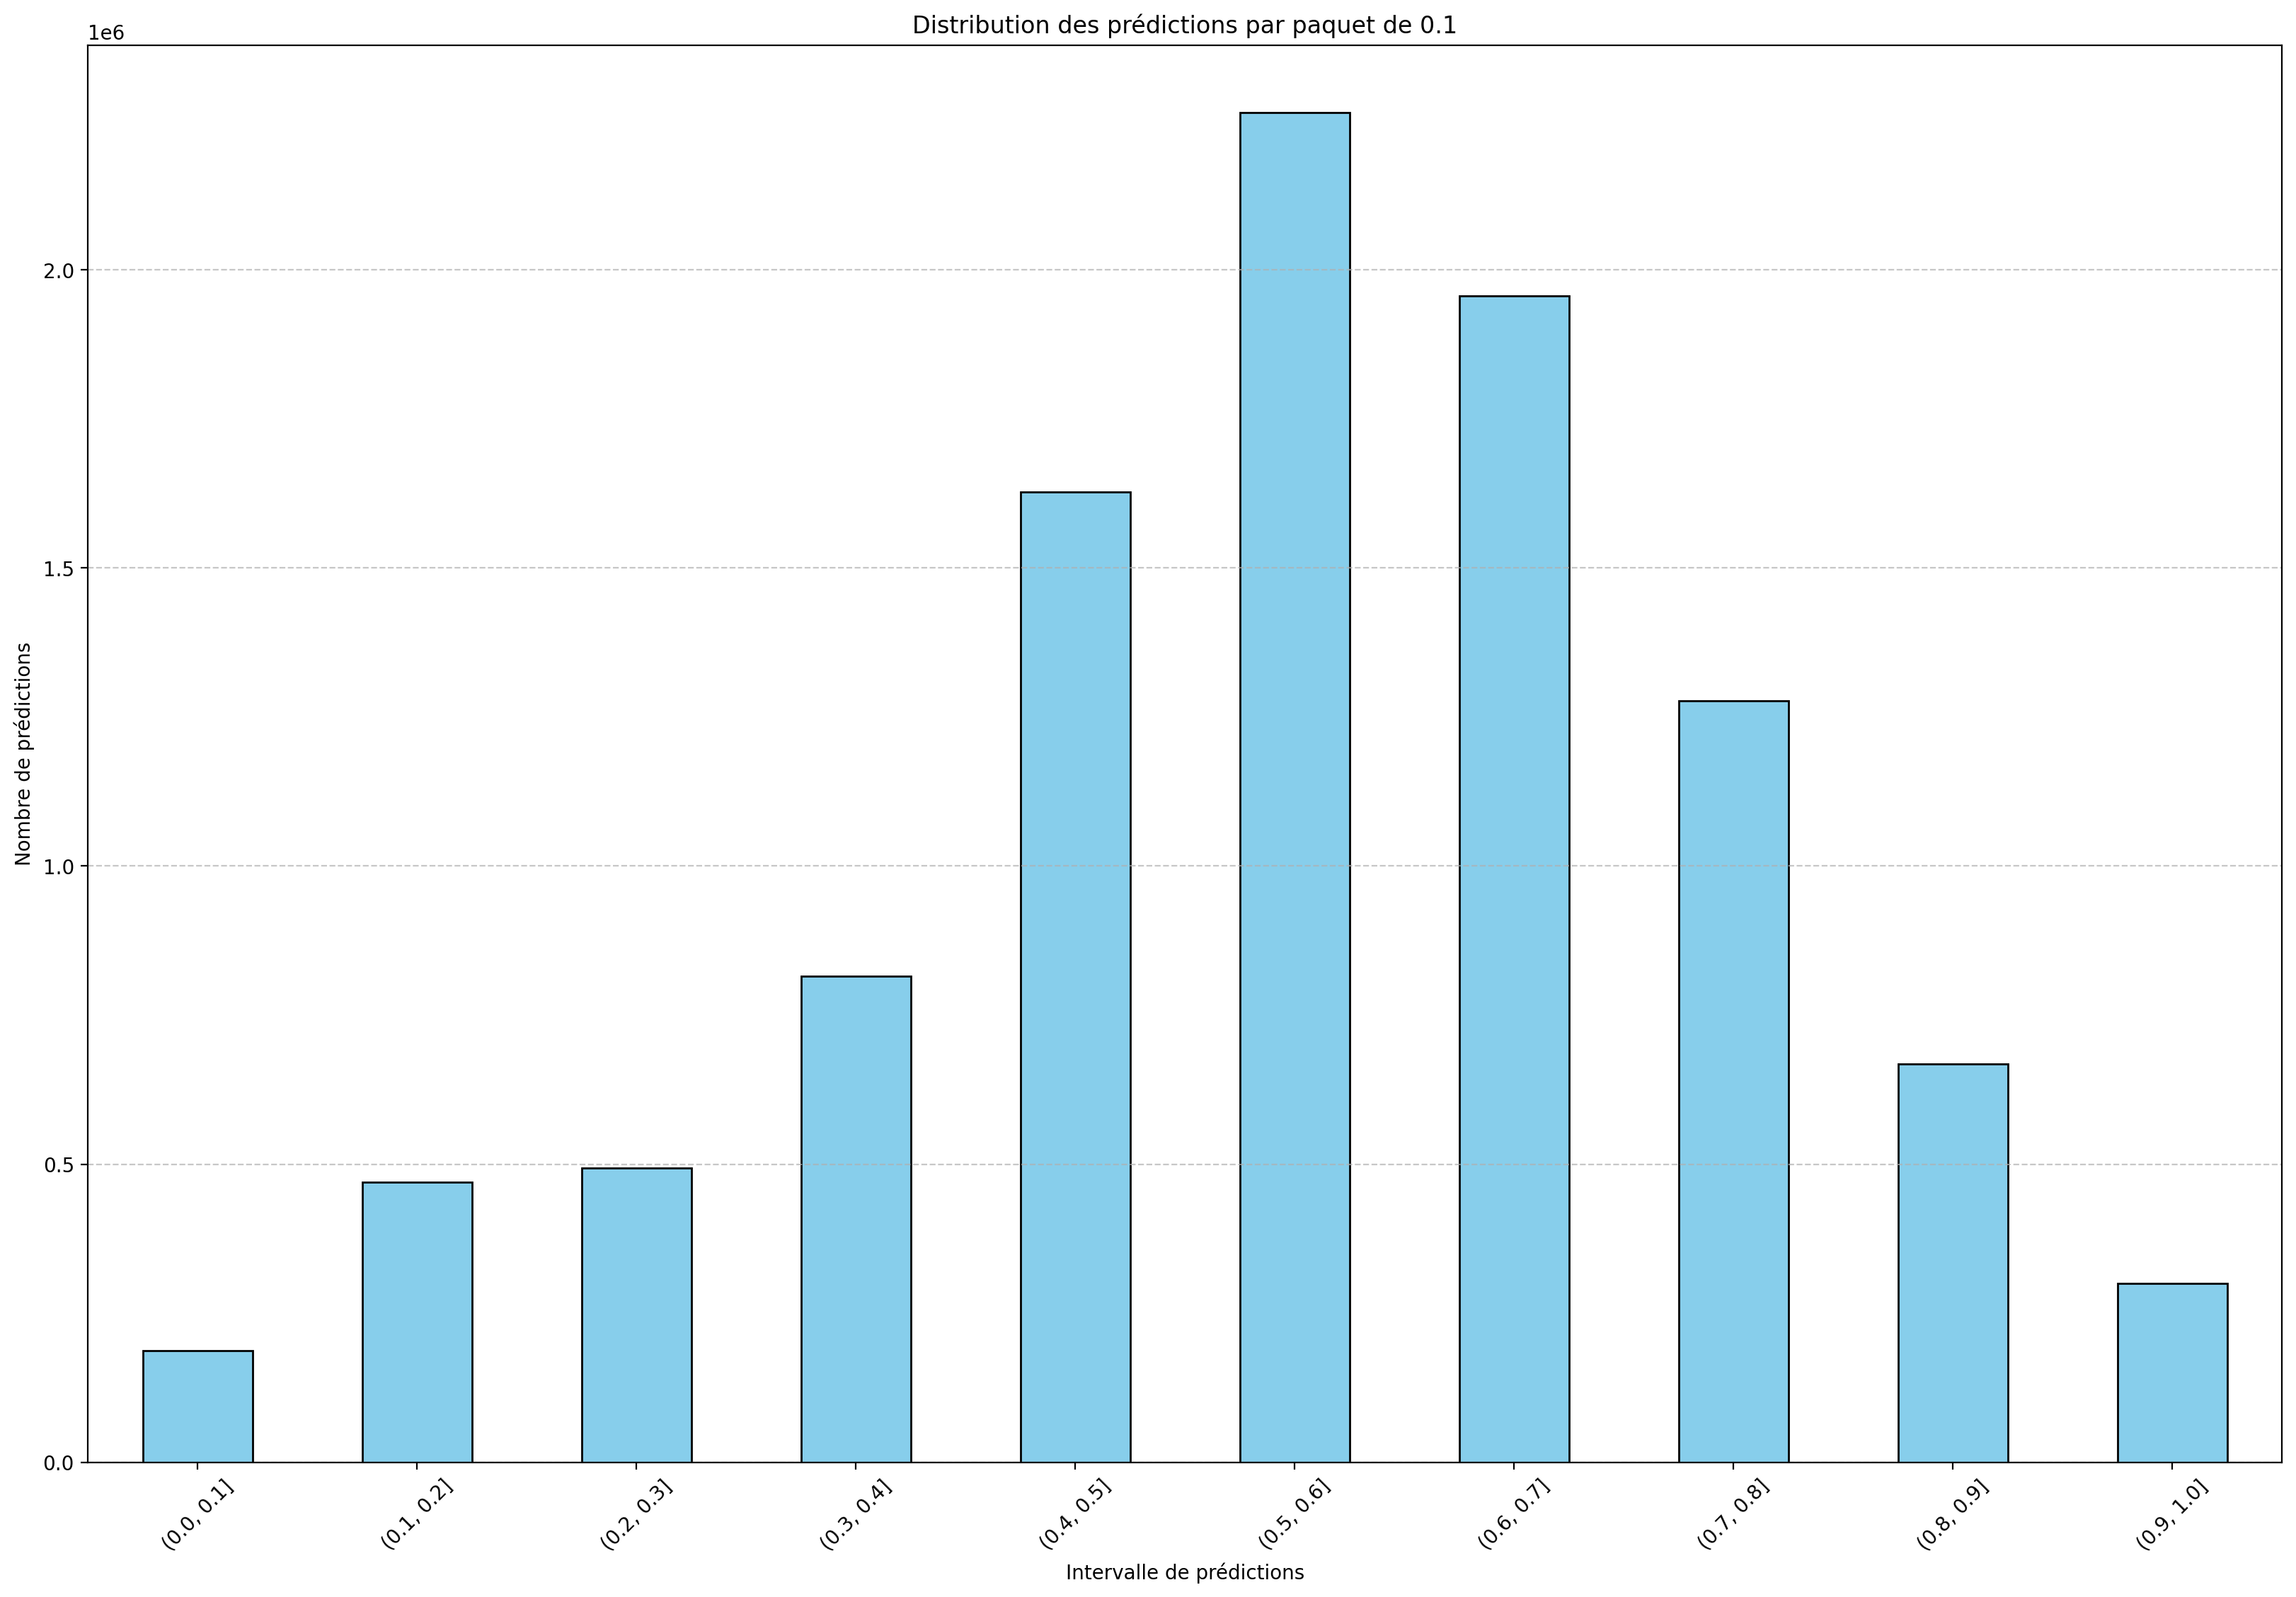

In [40]:
# Convertir les prédictions en pandas si ce n'est pas déjà fait
predictions_pandas['prediction_bin'] = pd.cut(predictions_pandas['prediction'], bins=np.arange(0, 1.1, 0.1))

# Compter le nombre de prédictions dans chaque intervalle
bin_counts = predictions_pandas['prediction_bin'].value_counts().sort_index()

# Tracer l'histogramme
bin_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Distribution des prédictions par paquet de 0.1")
plt.xlabel("Intervalle de prédictions")
plt.ylabel("Nombre de prédictions")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [19]:
evaluate_at_k(predictions_pandas, k=10, threshold=0.9)

{'precision': np.float64(0.8965981573352232),
 'recall': np.float64(0.00730908079637783),
 'ndcg': np.float64(0.9010117241371491),
 'map': np.float64(0.9276841658126883)}

Calculating metrics for k=1...
Calculating metrics for k=2...
Calculating metrics for k=3...
Calculating metrics for k=4...
Calculating metrics for k=5...
Calculating metrics for k=6...
Calculating metrics for k=7...
Calculating metrics for k=8...
Calculating metrics for k=9...
Calculating metrics for k=10...
Calculating metrics for k=11...
Calculating metrics for k=12...
Calculating metrics for k=13...
Calculating metrics for k=14...
Calculating metrics for k=15...
Calculating metrics for k=16...
Calculating metrics for k=17...
Calculating metrics for k=18...
Calculating metrics for k=19...
Calculating metrics for k=20...
Calculating metrics for k=21...
Calculating metrics for k=22...
Calculating metrics for k=23...
Calculating metrics for k=24...
Calculating metrics for k=25...
Calculating metrics for k=26...
Calculating metrics for k=27...
Calculating metrics for k=28...
Calculating metrics for k=29...
Calculating metrics for k=30...
Calculating metrics for k=31...
Calculating metri

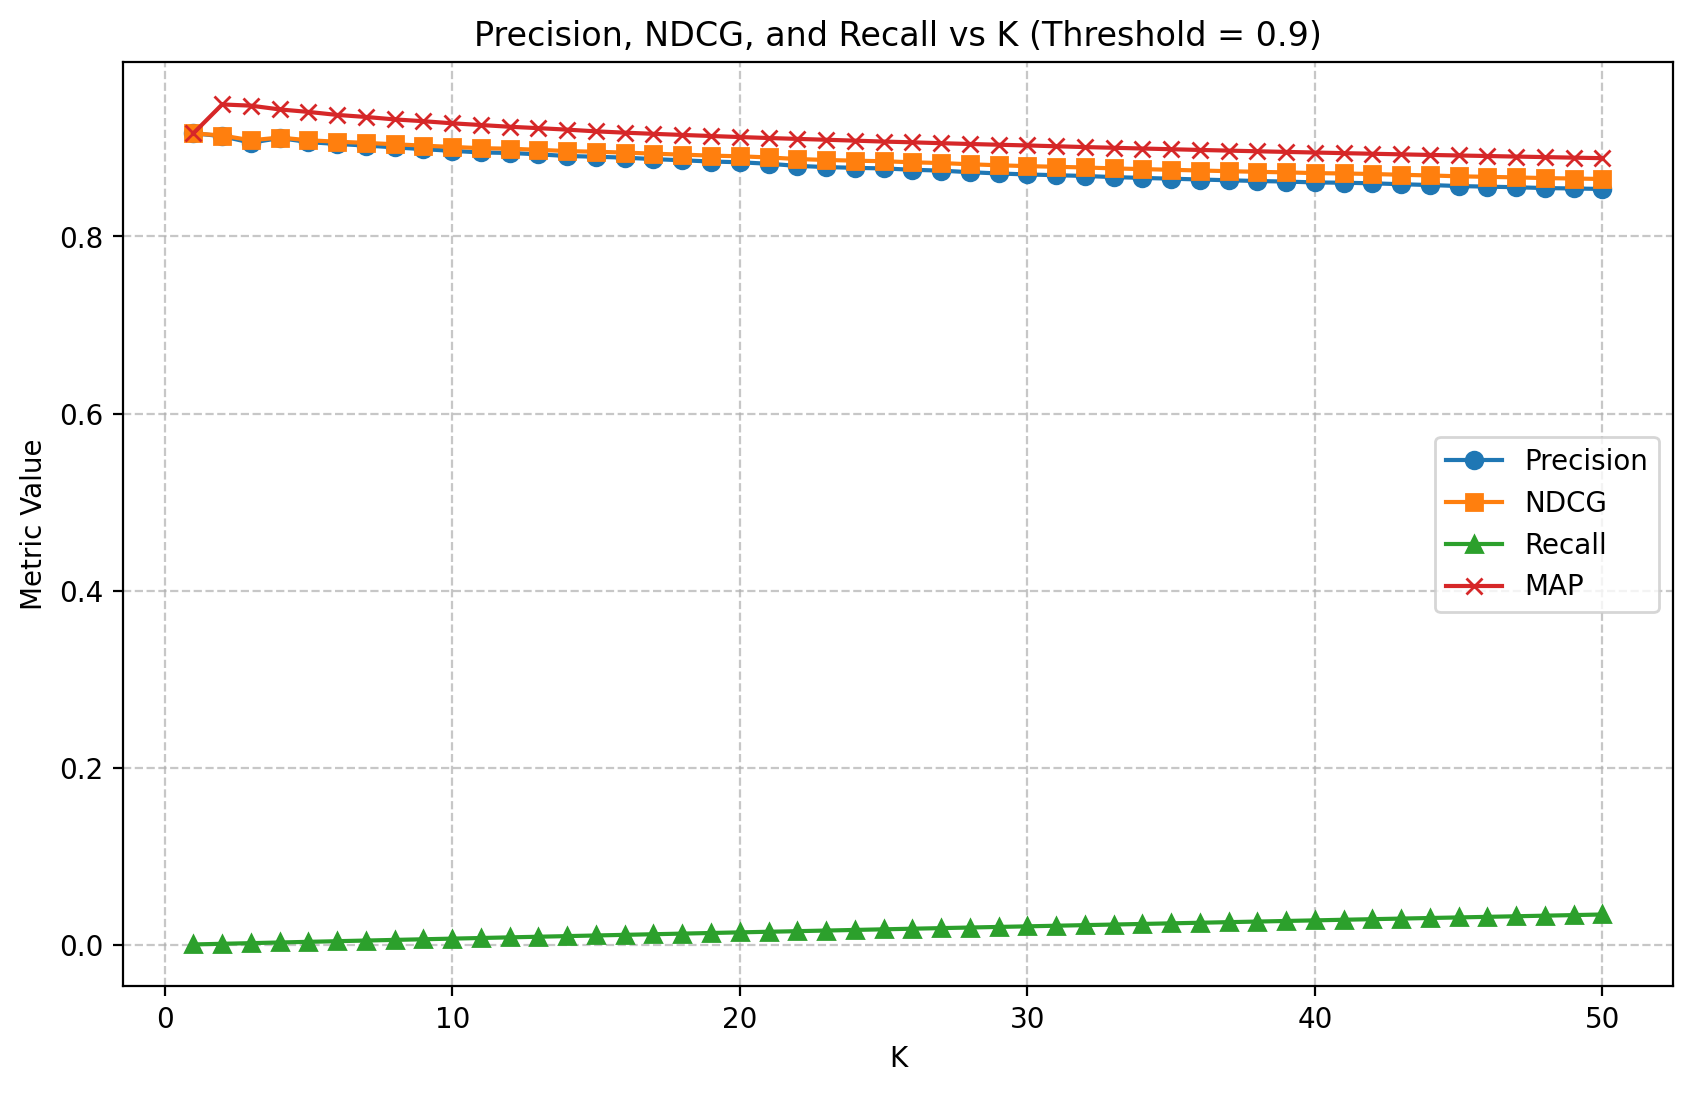

In [20]:
# Initialiser les listes pour stocker les résultats
ks = range(1, 51)
precisions = []
ndcgs = []
recalls = []
maps = []

# Calculer les métriques pour chaque valeur de k
for k in ks:
    print(f"Calculating metrics for k={k}...")
    evaluate = evaluate_at_k(predictions_pandas, k, threshold=0.9)   
    precisions.append(evaluate['precision'])
    ndcgs.append(evaluate['ndcg'])
    recalls.append(evaluate['recall'])
    maps.append(evaluate['map'])

# Tracer les résultats
plt.figure(figsize=(10, 6))
plt.plot(ks, precisions, label="Precision", marker='o')
plt.plot(ks, ndcgs, label="NDCG", marker='s')
plt.plot(ks, recalls, label="Recall", marker='^')
plt.plot(ks, maps, label="MAP", marker='x')
plt.title("Precision, NDCG, and Recall vs K (Threshold = 0.9)")
plt.xlabel("K")
plt.ylabel("Metric Value")
plt.legend()
plt.grid(axis='both', linestyle='--', alpha=0.7)
plt.show()

In [9]:
for rank in [10, 25, 50, 100]:
    als = ALS(
        maxIter=15,
        regParam=0.01,
        rank=rank,
        userCol="user_id_index",
        itemCol="video_id_index",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True
    )
    model = als.fit(transformed)
    predictions = model.transform(small_matrix_transformed)
    predictions_pandas = predictions.toPandas()
    metrics = evaluate_at_k(predictions_pandas, k=10,threshold=0.9)  # ou ton éval
    print(f"Rank = {rank}, NDCG@10 = {metrics['ndcg']:.4f}, MAP@10 = {metrics['map']:.4f}, Precision@10 = {metrics['precision']:.4f}, Recall@10 = {metrics['recall']:.4f}")


Rank = 10, NDCG@10 = 0.6881, MAP@10 = 0.7802, Precision@10 = 0.6661, Recall@10 = 0.0986
Rank = 25, NDCG@10 = 0.7191, MAP@10 = 0.8091, Precision@10 = 0.6934, Recall@10 = 0.1023
Rank = 50, NDCG@10 = 0.7400, MAP@10 = 0.8253, Precision@10 = 0.7132, Recall@10 = 0.1049
Rank = 100, NDCG@10 = 0.7560, MAP@10 = 0.8394, Precision@10 = 0.7278, Recall@10 = 0.1068


In [9]:
import os
print("JAVA_HOME =", os.environ.get("JAVA_HOME"))


JAVA_HOME = C:\Program Files\Java\jdk-17.0.1


In [8]:
for rank in [10, 25, 50, 100]:
    als = ALS(
        maxIter=30,
        regParam=0.01,
        rank=rank,
        userCol="user_id_index",
        itemCol="video_id_index",
        ratingCol="rating",
        coldStartStrategy="drop",
        nonnegative=True
    )
    model = als.fit(transformed)
    predictions = model.transform(small_matrix_transformed)
    predictions_pandas = predictions.toPandas()
    metrics = evaluate_at_k(predictions_pandas, k=10,threshold=0.9)  # ou ton éval
    print(f"Rank = {rank}, NDCG@10 = {metrics['ndcg']:.4f}, MAP@10 = {metrics['map']:.4f}, Precision@10 = {metrics['precision']:.4f}, Recall@10 = {metrics['recall']:.4f}")


ERROR:root:Exception while sending command.
Traceback (most recent call last):
  File "d:\programmation\FinalProject_2025_Alexis.LE-TRUNG\.venv\lib\site-packages\py4j\clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "C:\Users\letru\AppData\Local\Programs\Python\Python310\lib\socket.py", line 705, in readinto
    return self._sock.recv_into(b)
ConnectionResetError: [WinError 10054] Une connexion existante a dû être fermée par l’hôte distant

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "d:\programmation\FinalProject_2025_Alexis.LE-TRUNG\.venv\lib\site-packages\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "d:\programmation\FinalProject_2025_Alexis.LE-TRUNG\.venv\lib\site-packages\py4j\clientserver.py", line 539, in send_command
    raise Py4JNetworkError(
py4j.protocol.Py4JNetworkError: Error while sending o

ConnectionRefusedError: [WinError 10061] Aucune connexion n’a pu être établie car l’ordinateur cible l’a expressément refusée